# Neo4J v057 test1 - Trellis : Sample based Analysis

    -  Check the success case only based on outputs
    -  Load the account info from Google Cloud Storage
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [33]:
#!pip3 install -U py2neo

# *** add python path of py2neo in system

#!pip3 install -U neotime
#!pip3 install -U neobolt

### Import Packages

In [79]:
import py2neo as neo
from py2neo import Graph

from google.cloud import storage
import yaml

import pandas as pd
import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Neo4J DB

In [35]:
## Option 1 : Read DB and Account Information in Google Storage (YAML)

# create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket('gbsc-gcp-project-mvp-{env}-trellis')
# get bucket data as blob
blob = bucket.get_blob('credentials/{env}-wgs35.yaml')
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

## Option 2 : Read DB and Account Information in VM (TXT)
# f=open("./authentication/account.txt","r")
# lines=f.readlines()
# db=lines[0][:-1]
# username=lines[1][:-1]
# password=lines[2][:-1]
# f.close()

## Main Account
graph = Graph(account['NEO4J_SCHEME']+'://'+account['NEO4J_HOST']+":"+str(account['NEO4J_PORT']), auth=(account['NEO4J_USER'],account['NEO4J_PASSPHRASE']))

## Generate Sample Status Table

### The number of nodes (Fastq, Ubam, Vcf, Cram, Crai) 

In [36]:
# Fastq
#query = "MATCH (s:Sample)-[:HAS]->(f:Fastq) RETURN s.sample AS sample, COUNT(f) AS fastq"
query = "MATCH (s:Sample), (f:Fastq) WHERE s.sample = f.sample RETURN s.sample AS sample, COUNT(f) AS fastq"
#query = "Match (j:sample), (f:Fastq) WHERE f.sample = j.sample RETURN j.sample AS sample, count(f) AS fastq"
num_fastq = graph.run(query).to_data_frame()
num_fastq.set_index('sample')

# Fastq RG
#query = "MATCH (s:Sample)-[:HAS]->(f:Fastq) RETURN s.sample AS sample, f.readGroup AS rg, count(f.readGroup) as rg_cnt"
query = "MATCH (s:Sample), (f:Fastq) WHERE s.sample = f.sample RETURN s.sample AS sample, f.readGroup AS rg, count(f.readGroup) as rg_cnt"
#query = "Match (j:sample), (f:Fastq) WHERE f.sample = j.sample RETURN j.sample AS sample, count(f) AS fastq"
num_fastq_rg = graph.run(query).to_data_frame()
num_fastq_rgm=num_fastq_rg.loc[num_fastq_rg['rg_cnt']==2,['sample','rg']]

num_fastq_rgu=num_fastq_rgm['sample'].value_counts().rename_axis('sample').to_frame('fastq_rg')
#num_fastq_rgu.rename(columns={'sample': 'fastq_rg'}, inplace=True)
num_fastq_rgu.reset_index(inplace=True)
num_fastq_rgu.set_index('sample')


# Ubam
query = "Match (s:Sample), (u:Ubam) WHERE s.sample = u.sample RETURN s.sample AS sample, count(u) AS ubam, count(distinct u.readGroup) as ubam_rg"
#query = "Match (s:Sample)-[*]->(u:Ubam) RETURN DISTINCT s.sample AS sample, count(distinct u) AS ubam, count(distinct u.readGroup) as ubam_rg"
num_ubam = graph.run(query).to_data_frame()
num_ubam.set_index('sample')

# Vcf
query = "Match (s:Sample), (v:Merged:Vcf) WHERE s.sample = v.sample RETURN s.sample AS sample, count(v) AS vcf"
#query = "Match (s:Sample)-[*]->(v:Merged:Vcf) RETURN DISTINCT s.sample AS sample, count(distinct v) AS vcf"
num_vcf = graph.run(query).to_data_frame()
num_vcf.set_index('sample')

# Cram
query = "Match (s:Sample), (cm:Cram) WHERE s.sample = cm.sample RETURN s.sample AS sample, count(cm) AS cram"
#query = "Match (s:Sample)-[*]->(cm:Cram) RETURN DISTINCT s.sample AS sample, count(distinct cm) AS cram"
num_cram = graph.run(query).to_data_frame()
num_cram.set_index('sample')

# Crai
query = "Match (s:Sample), (ci:Crai) WHERE s.sample = ci.sample RETURN s.sample AS sample, count(ci) AS crai"
#query = "Match (s:Sample)-[*]->(ci:Crai) RETURN DISTINCT s.sample AS sample, count(distinct ci) AS crai"
num_crai = graph.run(query).to_data_frame()
num_crai.set_index('sample')
print("")

### The number of jobs (FQ2U, GATK) 

In [37]:
# Fq2u
query = "Match (s:Sample), (e:Job:Dsub {name:'fastq-to-ubam'}) WHERE s.sample = e.sample RETURN s.sample AS sample, count(e) AS job_fq2u"
#query = "Match (s:Sample)-[*]->(e:Job:Dsub {name:'fastq-to-ubam'}) RETURN s.sample AS sample, count(distinct e) AS job_fq2u"
num_fq2u = graph.run(query).to_data_frame()
num_fq2u.set_index('sample')

# Gatk
query = "Match (s:Sample), (g:Job:CromwellWorkflow) WHERE s.sample = g.sample RETURN s.sample AS sample, count(g) AS job_gatk"
#query = "Match (s:Sample)-[*]->(g:Job:CromwellWorkflow) RETURN s.sample AS sample, count(distinct g) AS job_gatk"
num_gatk = graph.run(query).to_data_frame()
num_gatk.set_index('sample')
print("")

### Merge all node and job dfs to one df

In [38]:
num_fastq_rgu.head()

,sample,fastq_rg
0,SHIP5141891,6
1,SHIP5141889,6
2,SHIP4954756,4
3,SHIP5141914,4
4,SHIP5125882,4


In [39]:
#-- only nodes
#sample_qc_df=num_fastq.merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer')
#columnlist=["sample","fastq","ubam","vcf","cram","crai"]

#-- nodes and jobs
sample_qc_df=num_fastq.merge(num_fastq_rgu, how='outer').merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer').merge(num_fq2u,how='outer').merge(num_gatk,how='outer')
columnlist=["sample","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]
numsample=len(sample_qc_df)
print("The number of samples : " + str(numsample) + "\n")

sample_qc_df=sample_qc_df[columnlist]
sample_qc_df.fillna(0,inplace=True)
#sample_qc_df.head(3)

The number of samples : 288



### Classification based on sample status and success.

In [40]:
##-- Passed

#- 1. Successful jobs
sample_qc_df.loc[(sample_qc_df['ubam']==sample_qc_df['fastq']/2)&(sample_qc_df['ubam_rg']==sample_qc_df['fastq_rg'])&(sample_qc_df['vcf']==1)&(sample_qc_df['cram']==1) \
                                   &(sample_qc_df['crai']==1)&(sample_qc_df['job_fq2u']==sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==1),'status']="success"
#- 2. Duplicated jobs
sample_qc_df.loc[(sample_qc_df['ubam']==sample_qc_df['fastq']/2)&(sample_qc_df['ubam_rg']==sample_qc_df['fastq_rg'])&(sample_qc_df['vcf']==1)&(sample_qc_df['cram']==1) \
                                   &(sample_qc_df['crai']==1)&((sample_qc_df['job_fq2u']>sample_qc_df['fastq']/2)|(sample_qc_df['job_gatk']>1)),'status']="duplicated jobs"
#- 3. Duplicated jobs and nodes
sample_qc_df.loc[((sample_qc_df['ubam_rg']==sample_qc_df['fastq_rg'])&(sample_qc_df['ubam']>sample_qc_df['fastq']/2)|(sample_qc_df['vcf']>1)|(sample_qc_df['cram']>1) \
                                 |(sample_qc_df['crai']>1))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)|(sample_qc_df['job_gatk']>=1)),'status']="duplicated nodes"
#- Success 
sample_qc_df.loc[(sample_qc_df['status'].isin(["success", "duplicated jobs", "duplicated nodes"])), 'pass'] = "pass"


##-- failed
#- 4. no fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['job_fq2u']<sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==0)),'status']="no fq2u"
#- 5. failed fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==0)),'status']="failed fq2u"
#- 6. failed gatk jobs
sample_qc_df.loc[(sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&((sample_qc_df['vcf']<1)|(sample_qc_df['cram']<1) \
                                   |(sample_qc_df['crai']<1))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']>=1)),'status']="failed gatk"
#- 7. no gatk jobs
sample_qc_df.loc[((sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0)&(sample_qc_df['job_gatk']==0)),'status']="no gatk"
#- 8. missing rg jobs
sample_qc_df.loc[(sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['fastq_rg']!=sample_qc_df['ubam_rg']),'status']="missing rg"


#- Fail
sample_qc_df.loc[(sample_qc_df['status'].isin(["no fq2u", "failed fq2u", "failed gatk", "no gatk","missing rg"])), 'pass'] = "fail"

##-- Check unclassified samples.
num_unclassified = len(sample_qc_df[sample_qc_df.status.isna()==True])
print("The number of unclassified samples : " + str(num_unclassified)+"\n")

if num_unclassified != 0 :
    display(sample_qc_df[sample_qc_df.status.isna()==True])
    

The number of unclassified samples : 0



In [41]:
##-- Display of this table
pd.set_option('display.float_format', lambda x: '%.f' % x)

display(sample_qc_df[sample_qc_df['status']=='success'].head(2))
display(sample_qc_df[sample_qc_df['status']=='duplicated jobs'].head(13))
display(sample_qc_df[sample_qc_df['status']=='duplicated nodes'].head(7))
display(sample_qc_df[sample_qc_df['status']=='no fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='failed fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='no gatk'].head(4))
display(sample_qc_df[sample_qc_df['status']=='failed gatk'].head(5))
display(sample_qc_df[sample_qc_df['status']=='missing rg'].head(9))

,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass
0,SHIP4962328,8,4,4,4,1,1,1,4,1,success,pass
1,SHIP4962320,8,4,4,4,1,1,1,4,1,success,pass


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass
23,SHIP5119431,8,4,4,4,0,0,0,4,0,no gatk,fail
168,SHIP4954745,8,4,4,4,0,0,0,3,0,no gatk,fail


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass
5,SHIP4962321,8,4,4,4,0,0,0,4,1,failed gatk,fail
9,SHIP5119432,8,4,4,4,0,1,1,4,1,failed gatk,fail
17,SHIP5119457,8,4,4,4,0,0,0,4,1,failed gatk,fail
35,SHIP5119477,8,4,4,4,0,0,0,4,1,failed gatk,fail
48,SHIP4962334,8,4,4,4,0,0,0,4,1,failed gatk,fail


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass


## Generate Status Table

### The number of samples by status and success

In [100]:
stat_status_qc=sample_qc_df['status'].value_counts().to_frame()
stat_status_qc['rate']=100*(stat_status_qc['status']/numsample)

stat_status_qc=stat_status_qc.reindex(index = ['success', 'duplicated jobs', 'duplicated nodes', 'no fq2u', 'failed fq2u', 'no gatk', 'failed gatk','missing rg'])
stat_status_qc=stat_status_qc.replace(np.nan,0)
display(stat_status_qc)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Success Samples : " + str(sum(stat_status_qc['status'][0:3])))
print("Failed Samples : " + str(sum(stat_status_qc['status'][3:7])))
print("Success Rate : " + str(sum(stat_status_qc['rate'][0:3])) + "%")
print("Failed Rate : " + str(sum(stat_status_qc['rate'][3:7])) + "%")

,status,rate
success,265.00,92.01
duplicated jobs,0.00,0.00
duplicated nodes,0.00,0.00
no fq2u,0.00,0.00
failed fq2u,0.00,0.00
no gatk,2.00,0.69
failed gatk,21.00,7.29
missing rg,0.00,0.00


Success Samples : 265.0
Failed Samples : 23.0
Success Rate : 92.01388888888889%
Failed Rate : 7.986111111111112%


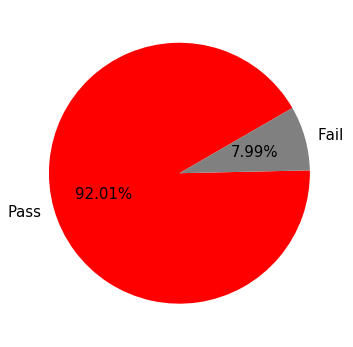

<Figure size 432x288 with 0 Axes>

In [99]:
from matplotlib import style
import matplotlib as mpl
style.use('ggplot')

fig = plt.figure(1, figsize=(6,6))
labels = ['Pass','Fail']
colors = ['red','grey']
ratio = [sum(stat_status_qc['rate'][0:3]),sum(stat_status_qc['rate'][3:7])]
patches, texts, autotexts=plt.pie(ratio, labels=labels, colors=colors, autopct='%.2f%%', shadow=False, startangle=30, textprops={'fontsize': 15})
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
plt.show()
plt.savefig('./success_rate.png')

## Check dstat message of successful samples
### (Hold :  Check the relationship informaiton of successful samples)

### fq2u issued relationship of successful samples

In [43]:
# success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
# print("The number of success samples: " + str(len(success_sample_df)))
# success_sample=success_sample_df['sample'].to_list()

# query = "Match (:Fastq)-[:INPUT_TO]->(j:Job:Dsub) WHERE j.name='fastq-to-ubam' and  not (j)-[:OUTPUT]->(:Ubam) and j.sample IN {} RETURN distinct j.sample AS sample_no_fq2utoubam".format(str(success_sample))
# norelation_ubam = graph.run(query).to_data_frame()
# print("The number of samples without the relationship between fq2u and ubam: " + str(len(norelation_ubam)))
# print("\n")

# display(norelation_ubam.head(3))

### gatk issued relationship of successful samples

In [44]:
# success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
# print("The number of success samples: " + str(len(success_sample_df)))
# success_sample=norelation_sample_df['sample'].to_list()

# query = "Match (j:Job:CromwellWorkflow) WHERE (not (:Ubam)-[:INPUT_TO]->(j) or not (j)-[:OUTPUT]->(:Merged:Vcf) or not (j)-[:OUTPUT]->(:Cram) or not (j)-[:OUTPUT]->(:Crai)) and (j.sample IN {}) RETURN distinct j.sample AS sample_missed_output".format(str(success_sample))
# norelation_output = graph.run(query).to_data_frame()
# print("The number of samples without the relationship between gatk and outputs: " + str(len(norelation_output)))

# display(norelation_output.head(3))
# #display(set(norelation_sample)-set(norelation_dstat['sample']))

### Issued fq2u dstat message in successful samples

In [45]:
success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
print("The number of success samples: " + str(len(success_sample_df)))
success_sample=success_sample_df['sample'].to_list()

query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.name='fastq-to-ubam' and j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.readGroup AS RG, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(success_sample))
issued_fq2u_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as dstat message  : " + str(len(issued_fq2u_dstat)))

if(len(issued_fq2u_dstat)):
    ## Issued Sample List
    display(issued_fq2u_dstat.head(17))

    ## Classified by Messange
    display(issued_fq2u_dstat.groupby(['Message','status']).count())

The number of success samples: 265
The number of samples with 'FAILURE' as dstat message  : 0


### Issued gatk dstat message in successful samples

In [46]:
# success_sample_df = sample_qc_df[sample_qc_df['status']=='success']
# print("The number of success samples: " + str(len(success_sample_df)))
# success_sample=norelation_sample_df['sample'].to_list()

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(success_sample))
issued_gatk_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as dstat message  : " + str(len(issued_gatk_dstat)))


if(len(issued_gatk_dstat)):
    ## Issued Sample List
    display(issued_gatk_dstat.head(17))
    
    ## Classified by Message
    display(issued_gatk_dstat.groupby(['Message','status']).count())
    

The number of samples with 'FAILURE' as dstat message  : 81


,Message,log,sample,status
0,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5119463,FAILURE
1,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4962319,FAILURE
2,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4962327,FAILURE
3,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5119442,FAILURE
4,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4962329,FAILURE
5,t.googleapis.services.AbstractGoogleClient <in...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5141879,FAILURE
6,t.googleapis.services.AbstractGoogleClient <in...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5119443,FAILURE
7,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5119449,FAILURE
8,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5141881,FAILURE
9,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5119430,FAILURE


,,log,sample
Message,status,,
".googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:14:46 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:29:16 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:37:06 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 12:14:02 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 1:13:17 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow d65313c5-77ea-4c3f-bb77-c45a5aa46322 transitioned to state Failed\n",FAILURE,1,1
".googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 11:54:35 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 12:03:30 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 12:33:00 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 12:55:55 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 1:51:15 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 7d643302-e69e-43b7-881b-46cc1d268787 transitioned to state Failed\n",FAILURE,1,1
".googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 10:20:49 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 10:38:54 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 12:19:14 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 12:31:29 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 05, 2020 2:30:29 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 8b328db7-9a11-40cf-a142-e83cb834690d transitioned to state Failed\n",FAILURE,1,1
"ent.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 02, 2020 11:35:40 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 03, 2020 1:31:49 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 03, 2020 2:05:34 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 03, 2020 3:46:59 AM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 03, 2020 6:19:2

### Add issued dstat message

### (HOLD : Add relationship information)

In [47]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

success_re_dstat_df=pd.DataFrame()
success_re_dstat_df['sample']=success_sample_df['sample']

# ## Add the column in 'success_re_dstat_df' with input and output connections of fq2u jobs
# try:
#   success_re_dstat_df.loc[success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam']),'re_fq2u']="missing"
#   success_re_dstat_df.loc[~success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam']),'re_fq2u']="all"
# except:
#   print("No missing input and output connections of fq2u jobs")
#   if len(success_re_dstat_df):
#     success_re_dstat_df.loc[:,'re_fq2u']="all"

# ## Add the column in 'success_re_dstat_df' with input and output connections of gatk jobs
# try:
#   success_re_dstat_df.loc[success_re_dstat_df['sample'].isin(norelation_output['sample_missed_output']),'re_gatk']="missing"
#   success_re_dstat_df.loc[~success_re_dstat_df['sample'].isin(norelation_output['sample_missed_output']),'re_gatk']="all"
# except:
#   print("No missing input and output connections of gatk jobs")
#   if len(success_re_dstat_df):
#     success_re_dstat_df.loc[:,'re_gatk']="all"


## Add the column in 'success_re_dstat_df' with dstat message

try:
  issued_fq2u_dstat_df=issued_fq2u_dstat[['sample','RG','Message','log']]
  issued_fq2u_dstat_df.rename(columns={'RG': 'dstat_failed', 'Message': 'dstat_msg'}, inplace=True)
  success_re_dstat_df=success_re_dstat_df.merge(issued_fq2u_dstat_df, on='sample', how='left')
except:
  print("No issued dstat message of fq2u jobs")

try:
  issued_gatk_dstat_df=issued_gatk_dstat[['sample','Message','log']]
  issued_gatk_dstat_df.rename(columns={'Message': 'dstat_msg'}, inplace=True)
  issued_gatk_dstat_df.loc[:,'dstat_failed']="GATK"
  success_re_dstat_df=success_re_dstat_df.merge(issued_gatk_dstat_df, on='sample')

except:
  print("No issued dstat message of gatk jobs")

display(success_re_dstat_df.head(17))

# if len(norelation_ubam):
#   display(success_re_dstat_df[success_re_dstat_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam'])])
# if len(issued_fq2u_dstat):
#   display(success_re_dstat_df[success_re_dstat_df['sample'].isin(issued_fq2u_dstat['sample'])])


# sample_qc_df=sample_qc_df.merge(success_re_dstat_df, on='sample',how='outer')
# sample_qc_df=sample_qc_df[['sample','success','status','fastq','ubam','vcf','cram','crai','fq2u','gatk','dstat_failed','dstat_msg','log']]
# display(sample_qc_df.head(3))

# if len(norelation_ubam):
#   display(sample_qc_df[sample_qc_df['sample'].isin(norelation_ubam['sample_no_fq2utoubam'])])
# if len(issued_fq2u_dstat):
#   display(sample_qc_df[sample_qc_df['sample'].isin(issued_fq2u_dstat['sample'])])

No issued dstat message of fq2u jobs


,sample,dstat_msg,log,dstat_failed
0,SHIP5119449,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
1,SHIP5141879,t.googleapis.services.AbstractGoogleClient <in...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
2,SHIP4962324,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
3,SHIP5119437,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
4,SHIP4962327,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
5,SHIP5119430,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
6,SHIP5119451,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
7,SHIP4962319,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
8,SHIP5119442,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
9,SHIP5141883,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK


## Check dstat message of samples with duplicated jobs and nodes

### Duplicated Jobs (Fq2u)

In [48]:
dupjobs_sample_df = sample_qc_df[sample_qc_df['status']=='duplicated jobs']
print("The number of success samples with duplicated jobs: " + str(len(dupjobs_sample_df)))
dupjobs_sample=dupjobs_sample_df['sample'].to_list()

#display(dupjobs_sample_df)

#query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.name = 'fastq-to-ubam' and  j.sample IN {} and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))
query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.name = 'fastq-to-ubam' and  j.sample IN {} and j.duplicate=True RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))

dupfq2u_dstat = graph.run(query).to_data_frame()
print("The number of duplicated fq2u jobs : " + str(len(dupfq2u_dstat)))

## Issued Sample and Job List
display(dupfq2u_dstat.head())

## Classified by Messange
#dupfq2u_dstat.groupby(['Message','status']).count()

The number of success samples with duplicated jobs: 0
The number of duplicated fq2u jobs : 0


""


### Duplicated Jobs (GATK)

In [49]:
#dupjobs_sample_df = sample_qc_df[sample_qc_df['status']=='duplicated jobs']
#print("The number of success samples with duplicated jobs: " + str(len(dupjobs_sample_df)))
#dupjobs_sample=dupjobs_sample_df['sample'].to_list()

#display(dupjobs_sample_df)

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and j.duplicate=True RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))
dupgatk_dstat = graph.run(query).to_data_frame()
print("The number of duplicated gatk jobs : " + str(len(dupgatk_dstat)))

if len(dupgatk_dstat):
    display(dupgatk_dstat.head(3))
    dupgatk_dstat.groupby(['Message','status']).count()

The number of duplicated gatk jobs : 0


### Add issued dstat message (dup)

In [50]:
query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.name='fastq-to-ubam' and j.sample IN {} and not exists(j.duplicate) and not j.duplicate=True and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))
issued_dupfq2u_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as fq2u job's dstat message (Duplicated Job Status) : " + str(len(issued_dupfq2u_dstat)))

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not exists(j.duplicate) and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupjobs_sample))
issued_dupgatk_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as gatk job's dstat message (Duplicated Job Status) : " + str(len(issued_dupgatk_dstat)))

if(len(issued_dupfq2u_dstat)):
    ## Issued Sample List
    display(issued_dupfq2u_dstat.head(17))
    
    ## Classified by Message
    display(issued_dupgatk_dstat.groupby(['Message','status']).count())

if(len(issued_dupgatk_dstat)):
    ## Issued Sample List
    display(issued_dupgatk_dstat.head(17))
    
    ## Classified by Message
    display(issued_dupgatk_dstat.groupby(['Message','status']).count())

The number of samples with 'FAILURE' as fq2u job's dstat message (Duplicated Job Status) : 0
The number of samples with 'FAILURE' as gatk job's dstat message (Duplicated Job Status) : 0


In [51]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

dupjobs_re_dstat_df=pd.DataFrame()
dj_df1=pd.DataFrame()
dj_df2=pd.DataFrame()

if len(issued_dupfq2u_dstat):
  dj_df1=issued_dupfq2u_dstat[['sample','RG','Message','log']]

if len(issued_dupgatk_dstat):
  dj_df2=issued_dupgatk_dstat[['sample','Message','log']]
  dj_df2['RG']='GATK'
  
if not dj_df1.empty:
  if not dj_df2.empty:
    dupjobs_re_dstat_df=pd.concat([dj_df1,dj_df2],sort=False)
  else:
    dupjobs_re_dstat_df=dj_df1
else:
  if not dj_df2.empty:
    dupjobs_re_dstat_df=dj_df2

if not dupjobs_re_dstat_df.empty:
  dupjobs_re_dstat_df.rename(columns={'RG': 'dstat_failed', 'Message': 'dstat_msg'}, inplace=True)

In [52]:
display(dupjobs_re_dstat_df)

""


### Duplicated Job and Node

In [53]:
dupnodes_sample_df = sample_qc_df[sample_qc_df['status']=='duplicated nodes']
print("The number of success samples with duplicated nodes: " + str(len(dupnodes_sample_df)))
dupnodes_sample=dupnodes_sample_df['sample'].to_list()

display(dupnodes_sample_df)

# query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not exists(j.duplicate) and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupnodes_sample))
# dupnodes_dstat = graph.run(query).to_data_frame()
# print("The number of duplicated nodes: " + str(len(dupnodes_dstat)))
# display(dupnodes_dstat.head(3))

# dupnodes_dstat.groupby(['Message','status']).count()

The number of success samples with duplicated nodes: 0


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass


### Add issued dstat message (dup job and node)

In [54]:
query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.name='fastq-to-ubam' and j.sample IN {} and not exists(j.duplicate) and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupnodes_sample))
issued_dupnodefq2u_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as fq2u job's dstat message (Duplicated Job and Node Status) : " + str(len(issued_dupnodefq2u_dstat)))

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not exists(j.duplicate) and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(dupnodes_sample))
issued_dupnodegatk_dstat = graph.run(query).to_data_frame()
print("The number of samples with 'FAILURE' as gatk job's dstat message (Duplicated Job and Node Status) : " + str(len(issued_dupnodegatk_dstat)))

if(len(issued_dupnodefq2u_dstat)):
    ## Issued Sample List
    display(issued_dupnodefq2u_dstat.head(17))
    
    ## Classified by Message
    display(issued_dupnodefq2u_dstat.groupby(['Message','status']).count())

if(len(issued_dupnodegatk_dstat)):
    ## Issued Sample List
    display(issued_dupnodegatk_dstat.head(17))
    
    ## Classified by Message
    display(issued_dupnodegatk_dstat.groupby(['Message','status']).count())

The number of samples with 'FAILURE' as fq2u job's dstat message (Duplicated Job and Node Status) : 0
The number of samples with 'FAILURE' as gatk job's dstat message (Duplicated Job and Node Status) : 0


In [55]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

dupnodes_re_dstat_df=pd.DataFrame()
dn_df1=pd.DataFrame()
dn_df2=pd.DataFrame()

if len(issued_dupnodefq2u_dstat):
  dn_df1=issued_dupnodefq2u_dstat[['sample','RG','Message','log']]

if len(issued_dupnodegatk_dstat):
  dn_df2=issued_dupnodegatk_dstat[['sample','Message','log']]
  dn_df2['RG']='GATK'
  
if not dn_df1.empty:
  if not dn_df2.empty:
    dupnodes_re_dstat_df=pd.concat([dn_df1,dn_df2],sort=False)
  else:
    dupnodes_re_dstat_df=dn_df1
else:
  if not dn_df2.empty:
    dupnodes_re_dstat_df=dn_df2
        
#dupnodes_re_dstat_df=pd.concat([dn_df1,dn_df2],sort=False)

if not dupnodes_re_dstat_df.empty:
  dupnodes_re_dstat_df.rename(columns={'RG': 'dstat_failed', 'Message': 'dstat_msg'}, inplace=True)

display(dupnodes_re_dstat_df)

""


## Check the log list and the dstat message of issued jobs

### Failed Fq2u

In [56]:
failed_fq2u_sample_df = sample_qc_df[sample_qc_df['status']=='failed fq2u']
print("The number of samples with failed fq2u jobs: " + str(len(failed_fq2u_sample_df)))
failed_fq2u_sample=failed_fq2u_sample_df['sample'].to_list()

query = "Match (j:Job:Dsub)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not exists(j.duplicate) and not s.status='SUCCESS' RETURN j.sample AS sample, j.readGroup AS RG, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(failed_fq2u_sample))

failed_fq2u_dstat = graph.run(query).to_data_frame()
print("The number of failed fq2u jobs : " + str(len(failed_fq2u_dstat)))
display(failed_fq2u_dstat.head(4))

if(len(failed_fq2u_dstat)):
  display(failed_fq2u_dstat.groupby('Message').count())

The number of samples with failed fq2u jobs: 0
The number of failed fq2u jobs : 0


""


### Failed GATK

In [57]:
failed_gatk_sample_df = sample_qc_df[sample_qc_df['status']=='failed gatk']
print("The number of samples with failed gatk jobs: " + str(len(failed_gatk_sample_df))+"\n")
failed_gatk_sample=failed_gatk_sample_df['sample'].to_list()

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and not exists(j.duplicate) and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(failed_gatk_sample))
failed_gatk_dstat = graph.run(query).to_data_frame()
print("The number of original gatk jobs : " + str(len(failed_gatk_dstat)))

# dulicated failed gatks
query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} and j.duplicate=True and not s.status='SUCCESS' RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(failed_gatk_sample))
failed_gatk_dup = graph.run(query).to_data_frame()
print("The number of duplicated gatk jobs : " + str(len(failed_gatk_dup)))
#display(failed_gatk_dup.head(3))

query = "Match (j:Job:CromwellWorkflow)-[:STATUS]->(s:Dstat) WHERE j.sample IN {} RETURN j.sample AS sample, j.logging As log, s.status AS status, s.statusMessage AS Message".format(str(failed_gatk_sample))
failed_gatk_jobs = graph.run(query).to_data_frame()
print("The number of total gatk jobs : " + str(len(failed_gatk_jobs))+"\n")
#display(failed_gatk_dup.head(3))

display(failed_gatk_dstat.head(3))
if(len(failed_gatk_dstat)):
  display(failed_gatk_dstat.groupby('Message').count())

The number of samples with failed gatk jobs: 21

The number of original gatk jobs : 21
The number of duplicated gatk jobs : 0
The number of total gatk jobs : 21



,Message,log,sample,status
0,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP4962321,FAILURE
1,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5141884,FAILURE
2,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,SHIP5119457,FAILURE


,log,sample,status
Message,,,
"ent.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 9:58:50 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 9:58:50 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 9:58:50 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 9:58:50 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:22:38 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 0a6ca800-fb1c-4fa0-93fe-05064214a2a3 transitioned to state Failed\n",1,1,1
"googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:02:48 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:02:48 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:02:48 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:04:57 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:21:37 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow 1fac629e-e423-4ca8-9efe-5cc1cf3a2476 transitioned to state Failed\n",1,1,1
"googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:11:06 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:13:41 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:16:26 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:20:26 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:23:11 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nWorkflow b443b20a-4d20-45d8-8f7e-cffd59ed96ca transitioned to state Failed\n",1,1,1
"googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:15:38 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:17:53 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:19:33 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:24:33 PM com.google.api.client.googleapis.services.AbstractGoogleClient <init>\nWARNING: Application name is not set. Call Builder#setApplicationName.\nMar 04, 2020 10:29:03 PM com.google.ap

### Add failed dstat message

In [58]:
df2=failed_gatk_dstat[['sample','Message','log']]
df2['RG']='GATK'
df2.head()

,sample,Message,log,RG
0,SHIP4962321,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
1,SHIP5141884,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
2,SHIP5119457,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
3,SHIP4962334,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
4,SHIP5119452,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK


In [59]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

failed_re_dstat_df=pd.DataFrame()

if len(failed_fq2u_dstat):
  df1=failed_fq2u_dstat[['sample','RG','Message','log']]
else:
  df1=pd.DataFrame()

if len(failed_gatk_dstat):
  df2=failed_gatk_dstat[['sample','Message','log']]
  df2['RG']='GATK'
else:
  df2=pd.DataFrame() 

failed_re_dstat_df=pd.concat([df1,df2])
failed_re_dstat_df.rename(columns={'RG': 'dstat_failed', 'Message': 'dstat_msg'}, inplace=True)

In [60]:
dstat_df=pd.concat([success_re_dstat_df,dupjobs_re_dstat_df,dupnodes_re_dstat_df,failed_re_dstat_df],sort=False)
display(dstat_df.head(5))
# display(len(success_re_dstat_df))
# display(len(dupjobs_re_dstat_df))
# display(len(dupnodes_re_dstat_df))
# display(len(failed_re_dstat_df))

sample_qc_df=sample_qc_df.merge(dstat_df, on='sample',how='outer')

,sample,dstat_msg,log,dstat_failed
0,SHIP5119449,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
1,SHIP5141879,t.googleapis.services.AbstractGoogleClient <in...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
2,SHIP4962324,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
3,SHIP5119437,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK
4,SHIP4962327,ent.googleapis.services.AbstractGoogleClient <...,gs://gbsc-gcp-project-mvp-test-from-personalis...,GATK


In [61]:
columnlist=["sample","pass","status","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]
sample_qc_df_simple=sample_qc_df[columnlist]
sample_qc_df_simple.to_csv('sample-based-analysis-v057-simple.csv')

In [62]:
sample_qc_df=sample_qc_df[['sample','pass','status','fastq','ubam','vcf','cram','crai','job_fq2u','job_gatk','dstat_failed','dstat_msg','log']]
display(sample_qc_df)

sample_qc_df.to_csv('sample-based-analysis-v057-withDupDstatLog.csv')

,sample,pass,status,fastq,ubam,vcf,cram,crai,job_fq2u,job_gatk,dstat_failed,dstat_msg,log
0,SHIP4962328,pass,success,8,4,1,1,1,4,1,NaN,NaN,NaN
1,SHIP4962320,pass,success,8,4,1,1,1,4,1,NaN,NaN,NaN
2,SHIP5119455,pass,success,8,4,1,1,1,4,1,NaN,NaN,NaN
3,SHIP5119449,pass,success,8,4,1,1,1,4,1,GATK,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...
4,SHIP5141879,pass,success,8,4,1,1,1,4,1,GATK,t.googleapis.services.AbstractGoogleClient <in...,gs://gbsc-gcp-project-mvp-test-from-personalis...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,SHIP5141848,pass,success,8,4,1,1,1,4,1,NaN,NaN,NaN
284,SHIP5141865,pass,success,8,4,1,1,1,4,1,NaN,NaN,NaN
285,SHIP5125869,pass,success,8,4,1,1,1,4,1,NaN,NaN,NaN
286,SHIP5141857,pass,success,8,4,1,1,1,4,1,GATK,nt.googleapis.services.AbstractGoogleClient <i...,gs://gbsc-gcp-project-mvp-test-from-personalis...
